In [1]:
using JuMP, Gurobi, CSV, DataFrames, Plots


In [2]:
#Download Files
D = CSV.read("HW1_data/demand.csv", DataFrame, drop=1:1) |> Matrix
R = CSV.read("HW1_data/requirements.csv", DataFrame, drop=1:1) |> Matrix
A = CSV.read("HW1_data/availability.csv", DataFrame, drop=1:1) |> Matrix

h = CSV.read("HW1_data/holding.csv", DataFrame)[:, 2]
p = CSV.read("HW1_data/profit.csv", DataFrame)[:, 2]

pcnt = size(p)[1]
(mcnt, wcnt) = size(A)
(pcnt, wcnt, mcnt)


(20, 52, 500)

In [3]:
model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "TimeLimit", 60) # Good practice, forces solver to stop running

@variable(model, X[1:pcnt, 1:wcnt] >= 0) # total final product i in week j
@variable(model, sold[1:pcnt, 1:wcnt] >= 0)
@variable(model, start_amount[1:pcnt, 1:wcnt] >= 0) # amount of product i I begin week j with

#first column of start_amount should be all 0; (week j) past_leftover = (week j - 1) X - sold
@constraint(model, start_amount[:,1] .== 0)
@constraint(model, [j=2:wcnt], start_amount[:,j] == X[:,j-1] - sold[:,j-1]) 

# leftovers included in next week
@constraint(model, X .>= start_amount)

#Resource Constraint for Each Week
@constraint(model, R * (X - start_amount) .<= A)

# sold = min(X, D)
@constraint(model, sold .<= X)
@constraint(model, sold .<= D)

@objective(model, Max, sum(p' * sold) - sum(start_amount * h))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-05
Set parameter TimeLimit to value 60


29.98 sold[1,1] + 95.66 sold[2,1] + 67.95 sold[3,1] + 54.89 sold[4,1] + 56.75 sold[5,1] + 115.59 sold[6,1] + 63.52 sold[7,1] + 48.52 sold[8,1] + 101.33 sold[9,1] + 91.22 sold[10,1] + 55.34 sold[11,1] + 71.26 sold[12,1] + 39.91 sold[13,1] + 32.68 sold[14,1] + 54.7 sold[15,1] + 88.79 sold[16,1] + 137.06 sold[17,1] + 110.37 sold[18,1] + 48.46 sold[19,1] + 37.82 sold[20,1] + 29.98 sold[1,2] + 95.66 sold[2,2] + 67.95 sold[3,2] + 54.89 sold[4,2] + 56.75 sold[5,2] + 115.59 sold[6,2] + 63.52 sold[7,2] + 48.52 sold[8,2] + 101.33 sold[9,2] + 91.22 sold[10,2] + [[...2020 terms omitted...]] - 3.07 start_amount[20,23] - 1.6 start_amount[20,24] - 6.83 start_amount[20,25] - 8.84 start_amount[20,26] - 4 start_amount[20,27] - 6.87 start_amount[20,28] - 5.11 start_amount[20,29] - 8.65 start_amount[20,30] - 9.34 start_amount[20,31] - 46.47 start_amount[20,32] - 4.23 start_amount[20,33] - 9.92 start_amount[20,34] - 17.75 start_amount[20,35] - 4.05 start_amount[20,36] - 2.86 start_amount[20,37] - 6.7 start

In [4]:
optimize!(model)

Set parameter TimeLimit to value 60
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 30160 rows, 3120 columns and 352624 nonzeros
Model fingerprint: 0x76d80ee1
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [9e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 3e+05]
Presolve removed 1502 rows and 20 columns
Presolve time: 0.14s
Presolved: 3100 rows, 29676 columns, 346466 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1020
 AA' NZ     : 4.305e+04
 Factor NZ  : 9.358e+04 (roughly 14 MB of memory)
 Factor Ops : 2.951e+06 (less than 1 second per iteration)
 Threads    : 6

Barrier performed 0 iterations in 0.19 seconds (0.33 work units)
Barrier solve interrupted - model so

In [5]:
println("Sales Profit: $(sum(p' * JuMP.value.(sold)))")
println("Holding Costs: $(sum(JuMP.value.(start_amount) * h))")

Sales Profit: 1.369383048861513e6
Holding Costs: 6005.014626509439


# ci)

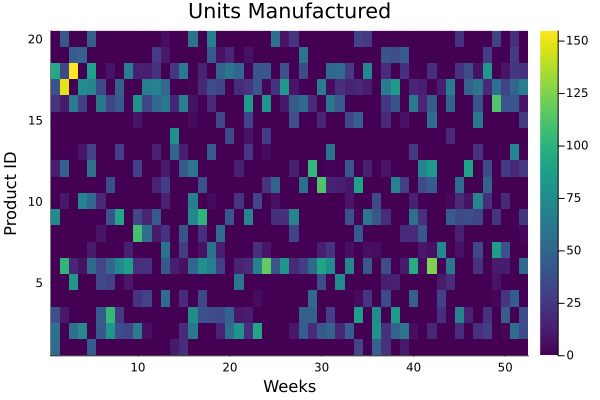

In [6]:
Plots.heatmap(JuMP.value.(X) - JuMP.value.(start_amount), color=:viridis, title="Units Manufactured", xlabel="Weeks", ylabel="Product ID")


# cii) Number of Product Types Manufactured > 0 in Week j vs. Week j

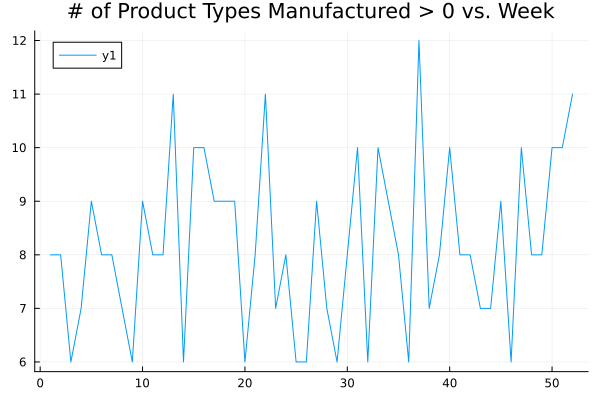

In [7]:
x = range(1, wcnt)
y = sum((JuMP.value.(X) - JuMP.value.(start_amount)) .> 0, dims = 1)'
plot(x, y, title = "# of Product Types Manufactured > 0 vs. Week")


# ciii) 

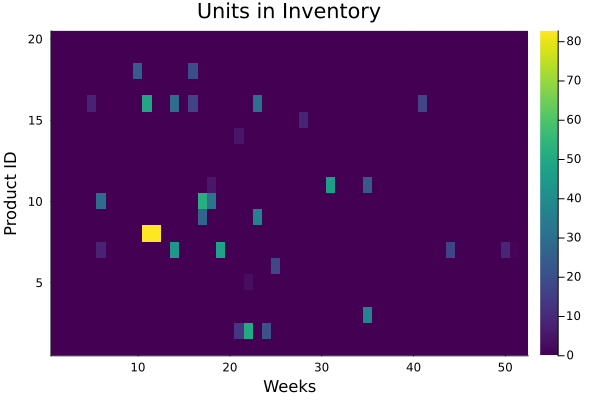

In [8]:
Plots.heatmap(JuMP.value.(start_amount), color=:viridis, title="Units in Inventory", xlabel="Weeks", ylabel="Product ID")


# d)

In [9]:
avail = JuMP.value.(A)
bought = JuMP.value.(R * (X - start_amount))
week = 30

total_utilized = sum((abs.(avail - bought) .< .0001)[:, week])
total_satisfied = sum((abs.(JuMP.value.(D) - JuMP.value.(sold)) .< .0001)[:, week])
println("Total # of fully utilized materials: $(total_utilized)")
println("Total # of products where demand is matched fully: $(total_satisfied)")
println("Holding Cost for Week 30: $(h[30])")

# Holding cost is low this week, so this week focuses more on buying materials than it is on maximizing profit. Saving up this week!


Total # of fully utilized materials: 8
Total # of products where demand is matched fully: 1
Holding Cost for Week 30: 8.65
